In [1352]:
df = bt.data['STRATEX-BINANCE-F']

In [346]:
def rolling_discretize_vectorized(df, window_size=120, n_bins=5):
    def discretize_last_point(window):
        if np.isnan(window).any() or len(np.unique(window)) < n_bins:
            return np.nan
        try:
            bins = pd.qcut(window, q=n_bins, labels=False, duplicates='drop')
            return bins[-1]
        except ValueError:
            return np.nan

    return df.rolling(window=window_size, min_periods=window_size).apply(discretize_last_point, raw=True)

In [1353]:
TOP_UNIVERSE = ['ARB-USDT', 'BNB-USDT', 'BTC-USDT', 'DOGE-USDT', 
    'ETH-USDT', 'MATIC-USDT', 'SOL-USDT', 'XRP-USDT', 
    'ADA-USDT', 'OP-USDT', 'LINK-USDT', 'SUI-USDT', 
    'AVAX-USDT', 'LTC-USDT', 'BCH-USDT']

In [529]:
import sklearn
from sklearn.metrics import mutual_info_score

In [524]:
log_returns = np.log(df['close']).diff()[TOP_UNIVERSE]
disc_windows_week_story_log_returns = rolling_discretize_vectorized(log_returns.fillna(0), window_size=48, n_bins=5)

/home/kt/myenv311/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [1177]:
def compute_mutual_info_matrix(df, n_bins=5):

    mi_matrix = pd.DataFrame(index=df.columns, columns=df.columns, dtype=float)

    for col1 in df.columns:
        for col2 in df.columns:
            mi_matrix.loc[col1, col2] = mutual_info_score(df[col1], df[col2])
    
    return mi_matrix
mi_df_log_returns = compute_mutual_info_matrix(disc_windows_week_story_log_returns.fillna(0))
mi_df_log_returns.style.background_gradient(cmap='viridis')


ticker,ARB-USDT,BNB-USDT,BTC-USDT,DOGE-USDT,ETH-USDT,MATIC-USDT,SOL-USDT,XRP-USDT,ADA-USDT,OP-USDT,LINK-USDT,SUI-USDT,AVAX-USDT,LTC-USDT,BCH-USDT
ticker,,,,,,,,,,,,,,,
ARB-USDT,0.970166,0.086309,0.100421,0.092062,0.130468,0.088388,0.093660,0.069560,0.094937,0.259573,0.091009,0.355292,0.098255,0.082630,0.081664
BNB-USDT,0.086309,1.566823,0.411829,0.344746,0.435611,0.344249,0.339565,0.316505,0.376464,0.126885,0.366871,0.055707,0.341305,0.352921,0.346252
BTC-USDT,0.100421,0.411829,1.566910,0.383546,0.565218,0.360849,0.376020,0.342836,0.391277,0.135979,0.378948,0.059095,0.366465,0.397721,0.385248
DOGE-USDT,0.092062,0.344746,0.383546,1.567855,0.398578,0.340466,0.331883,0.318445,0.363336,0.135181,0.350604,0.059890,0.336629,0.344853,0.340570
ETH-USDT,0.130468,0.435611,0.565218,0.398578,1.567399,0.405442,0.395373,0.349656,0.415141,0.163779,0.438134,0.065106,0.386751,0.419023,0.399424
MATIC-USDT,0.088388,0.344249,0.360849,0.340466,0.405442,1.558434,0.342524,0.299598,0.365796,0.133671,0.367106,0.052246,0.352530,0.330640,0.320525
SOL-USDT,0.093660,0.339565,0.376020,0.331883,0.395373,0.342524,1.565911,0.288117,0.350858,0.135184,0.349635,0.062068,0.370199,0.316784,0.319301
XRP-USDT,0.069560,0.316505,0.342836,0.318445,0.349656,0.299598,0.288117,1.567380,0.347563,0.102051,0.318123,0.049259,0.293578,0.327942,0.314812
ADA-USDT,0.094937,0.376464,0.391277,0.363336,0.415141,0.365796,0.350858,0.347563,1.567088,0.135632,0.388546,0.061727,0.365619,0.368240,0.355485


In [1178]:
# volumes_buy = df['buy_volume'][TOP_UNIVERSE]
# disc_windows_week_story_volume_buy = rolling_discretize_vectorized(volumes_buy.fillna(0), window_size=48 * 15, n_bins=5)
mi_df_volume_buy = compute_mutual_info_matrix(disc_windows_week_story_volume_buy.fillna(0))
mi_df_volume_buy.style.background_gradient(cmap='viridis')

ticker,ARB-USDT,BNB-USDT,BTC-USDT,DOGE-USDT,ETH-USDT,MATIC-USDT,SOL-USDT,XRP-USDT,ADA-USDT,OP-USDT,LINK-USDT,SUI-USDT,AVAX-USDT,LTC-USDT,BCH-USDT
ticker,,,,,,,,,,,,,,,
ARB-USDT,0.950304,0.072228,0.077246,0.072892,0.098637,0.065837,0.082681,0.068209,0.085592,0.238077,0.075000,0.301509,0.077162,0.070311,0.062042
BNB-USDT,0.072228,1.558937,0.333725,0.225360,0.347537,0.258813,0.264822,0.246684,0.285445,0.103548,0.260185,0.048067,0.238275,0.272283,0.248353
BTC-USDT,0.077246,0.333725,1.565046,0.250613,0.569126,0.295276,0.329729,0.287418,0.327656,0.114107,0.316723,0.044007,0.289330,0.332983,0.305611
DOGE-USDT,0.072892,0.225360,0.250613,1.550202,0.270110,0.209866,0.214984,0.235598,0.261645,0.099200,0.228179,0.040577,0.203484,0.250057,0.233482
ETH-USDT,0.098637,0.347537,0.569126,0.270110,1.564648,0.317942,0.342035,0.287506,0.339335,0.139659,0.341845,0.044848,0.297897,0.345618,0.307011
MATIC-USDT,0.065837,0.258813,0.295276,0.209866,0.317942,1.550003,0.266910,0.232105,0.299101,0.100629,0.261513,0.033705,0.241307,0.250645,0.223828
SOL-USDT,0.082681,0.264822,0.329729,0.214984,0.342035,0.266910,1.556812,0.228918,0.288242,0.104751,0.271981,0.047266,0.293104,0.244605,0.226740
XRP-USDT,0.068209,0.246684,0.287418,0.235598,0.287506,0.232105,0.228918,1.555650,0.284323,0.091892,0.247507,0.043489,0.213121,0.269236,0.247841
ADA-USDT,0.085592,0.285445,0.327656,0.261645,0.339335,0.299101,0.288242,0.284323,1.559168,0.118280,0.298908,0.048672,0.287740,0.296579,0.266854


In [1179]:
# volumes_sell = df['sell_volume'][TOP_UNIVERSE]
# disc_windows_week_story_volume_sell = rolling_discretize_vectorized(volumes_sell.fillna(0), window_size=48 * 15, n_bins=5)
mi_df_volume_sell = compute_mutual_info_matrix(disc_windows_week_story_volume_sell.fillna(0))
mi_df_volume_sell.style.background_gradient(cmap='viridis')

ticker,ARB-USDT,BNB-USDT,BTC-USDT,DOGE-USDT,ETH-USDT,MATIC-USDT,SOL-USDT,XRP-USDT,ADA-USDT,OP-USDT,LINK-USDT,SUI-USDT,AVAX-USDT,LTC-USDT,BCH-USDT
ticker,,,,,,,,,,,,,,,
ARB-USDT,0.950989,0.073857,0.078656,0.077239,0.102041,0.068584,0.084812,0.071462,0.087101,0.238865,0.076799,0.303342,0.078744,0.072322,0.063455
BNB-USDT,0.073857,1.558072,0.340750,0.234388,0.357752,0.268475,0.276133,0.255536,0.299868,0.107100,0.271046,0.047729,0.243837,0.282653,0.254306
BTC-USDT,0.078656,0.340750,1.565689,0.259866,0.573602,0.300696,0.338205,0.300296,0.339328,0.116822,0.324346,0.045538,0.292065,0.340412,0.311383
DOGE-USDT,0.077239,0.234388,0.259866,1.550498,0.282786,0.219307,0.223819,0.241826,0.271705,0.104672,0.234766,0.042471,0.213838,0.260623,0.241081
ETH-USDT,0.102041,0.357752,0.573602,0.282786,1.565056,0.324900,0.351963,0.296906,0.352050,0.142399,0.350492,0.046860,0.300314,0.354561,0.312232
MATIC-USDT,0.068584,0.268475,0.300696,0.219307,0.324900,1.550427,0.274167,0.242650,0.307803,0.103392,0.268670,0.035046,0.246771,0.259159,0.229637
SOL-USDT,0.084812,0.276133,0.338205,0.223819,0.351963,0.274167,1.557260,0.238739,0.299194,0.106859,0.286146,0.048384,0.301522,0.253580,0.237133
XRP-USDT,0.071462,0.255536,0.300296,0.241826,0.296906,0.242650,0.238739,1.556692,0.295238,0.094856,0.255871,0.044992,0.224562,0.275170,0.254551
ADA-USDT,0.087101,0.299868,0.339328,0.271705,0.352050,0.307803,0.299194,0.295238,1.558869,0.122678,0.307588,0.049574,0.292977,0.308729,0.277442


In [528]:
volumes_diff = (df['sell_volume'] - df['buy_volume'])[TOP_UNIVERSE]
disc_windows_week_story_volume_diff = rolling_discretize_vectorized(volumes_diff.fillna(0), window_size=48 * 15, n_bins=5)
mi_df_volume_diff = compute_mutual_info_matrix(disc_windows_week_story_volume_diff.fillna(0))
mi_df_volume_diff.style.background_gradient(cmap='viridis')

ticker,ARB-USDT,BNB-USDT,BTC-USDT,DOGE-USDT,ETH-USDT,MATIC-USDT,SOL-USDT,XRP-USDT,ADA-USDT,OP-USDT,LINK-USDT,SUI-USDT,AVAX-USDT,LTC-USDT,BCH-USDT
ticker,,,,,,,,,,,,,,,
ARB-USDT,0.976811,0.033419,0.046387,0.031735,0.051124,0.028821,0.040937,0.031625,0.033421,0.172552,0.033320,0.268865,0.035645,0.031222,0.027686
BNB-USDT,0.033419,1.572415,0.194153,0.132563,0.194018,0.143837,0.147805,0.135422,0.152290,0.057288,0.142285,0.023643,0.131066,0.139323,0.122911
BTC-USDT,0.046387,0.194153,1.571982,0.163076,0.330129,0.179229,0.200998,0.168335,0.182802,0.073983,0.174035,0.030985,0.165699,0.175792,0.157165
DOGE-USDT,0.031735,0.132563,0.163076,1.572218,0.161364,0.131445,0.135250,0.134932,0.137848,0.052655,0.132087,0.022160,0.121630,0.128946,0.116794
ETH-USDT,0.051124,0.194018,0.330129,0.161364,1.571208,0.187914,0.200648,0.166252,0.180106,0.081544,0.183274,0.029336,0.165900,0.176252,0.150496
MATIC-USDT,0.028821,0.143837,0.179229,0.131445,0.187914,1.566151,0.152811,0.133127,0.149415,0.054866,0.145852,0.017977,0.141933,0.132835,0.115269
SOL-USDT,0.040937,0.147805,0.200998,0.135250,0.200648,0.152811,1.571543,0.131909,0.148732,0.064784,0.146794,0.029146,0.163145,0.132274,0.120316
XRP-USDT,0.031625,0.135422,0.168335,0.134932,0.166252,0.133127,0.131909,1.571830,0.153367,0.048809,0.134794,0.022859,0.119644,0.138690,0.122623
ADA-USDT,0.033421,0.152290,0.182802,0.137848,0.180106,0.149415,0.148732,0.153367,1.571706,0.053979,0.146974,0.023191,0.135538,0.139406,0.126945


In [530]:
from sklearn.metrics import mutual_info_score
import numpy as np
import pandas as pd

def entropy(series):
    value_counts = series.value_counts(normalize=True)
    probs = value_counts.values
    return -np.sum(probs * np.log2(probs + 1e-10))

In [532]:
def joint_entropy(*columns):
    combined = list(zip(*columns))
    df_joint = pd.Series(combined).value_counts(normalize=True)
    probs = df_joint.values
    return -np.sum(probs * np.log2(probs + 1e-10))

def triple_mutual_information(df, col_x, col_y, col_z):
    Hx = entropy(df[col_x])
    Hy = entropy(df[col_y])
    Hz = entropy(df[col_z])
    
    Hxy = joint_entropy(df[col_x], df[col_y])
    Hxz = joint_entropy(df[col_x], df[col_z])
    Hyz = joint_entropy(df[col_y], df[col_z])
    
    Hxyz = joint_entropy(df[col_x], df[col_y], df[col_z])
    
    I_xyz = Hx + Hy + Hz - Hxy - Hxz - Hyz + Hxyz
    return I_xyz
from itertools import combinations

def build_mi_tensor(df):
    cols = df.columns
    mi_tensor = {}

    for comb in combinations(cols, 3):
        x, y, z = comb
        mi = triple_mutual_information(df, x, y, z)
        mi_tensor[comb] = mi
    
    return mi_tensor

In [533]:
mi_df_log_returns_triple = build_mi_tensor(disc_windows_week_story_log_returns)

In [534]:
mi_df_log_volumes_buy_triple = build_mi_tensor(disc_windows_week_story_volume_buy)

In [535]:
mi_df_log_volumes_sell_triple = build_mi_tensor(disc_windows_week_story_volume_sell)

In [536]:
mi_df_log_volumes_diff_triple = build_mi_tensor(disc_windows_week_story_volume_diff)

In [540]:
# mi_df_log_returns_triple

In [538]:
mi_df_log_returns.to_csv('mi_df_log_returns.csv')
mi_df_volume_buy.to_csv('mi_df_volume_buy.csv')
mi_df_volume_sell.to_csv('mi_df_volume_sell.csv')
mi_df_volume_diff.to_csv('mi_df_volume_diff.csv')

In [541]:
df_triple_mi_log_returns = pd.DataFrame(
    [(a, b, c, val) for (a, b, c), val in mi_df_log_returns_triple.items()],
    columns=["Asset1", "Asset2", "Asset3", "Mutual_Information"]
)
df_triple_mi_volume_buy = pd.DataFrame(
    [(a, b, c, val) for (a, b, c), val in mi_df_log_volumes_buy_triple.items()],
    columns=["Asset1", "Asset2", "Asset3", "Mutual_Information"]
)
df_triple_mi_volume_sell = pd.DataFrame(
    [(a, b, c, val) for (a, b, c), val in mi_df_log_volumes_sell_triple.items()],
    columns=["Asset1", "Asset2", "Asset3", "Mutual_Information"]
)
df_triple_mi_volume_diff = pd.DataFrame(
    [(a, b, c, val) for (a, b, c), val in mi_df_log_volumes_diff_triple.items()],
    columns=["Asset1", "Asset2", "Asset3", "Mutual_Information"]
)
df_triple_mi_log_returns.to_csv('df_triple_mi_log_returns.csv')
df_triple_mi_volume_buy.to_csv('df_triple_mi_volume_buy.csv')
df_triple_mi_volume_sell.to_csv('df_triple_mi_volume_sell.csv')
df_triple_mi_volume_diff.to_csv('df_triple_mi_volume_diff.csv')

In [542]:
df_triple_mi_volume_diff

,Asset1,Asset2,Asset3,Mutual_Information
0,ARB-USDT,BNB-USDT,BTC-USDT,0.17216174
1,ARB-USDT,BNB-USDT,DOGE-USDT,0.16601902
2,ARB-USDT,BNB-USDT,ETH-USDT,0.17321456
3,ARB-USDT,BNB-USDT,MATIC-USDT,0.12076861
4,ARB-USDT,BNB-USDT,SOL-USDT,0.17045711
...,...,...,...,...
450,LINK-USDT,LTC-USDT,BCH-USDT,-0.16545913
451,SUI-USDT,AVAX-USDT,LTC-USDT,0.23838297
452,SUI-USDT,AVAX-USDT,BCH-USDT,0.23801130
453,SUI-USDT,LTC-USDT,BCH-USDT,0.23754267


In [544]:
from collections import defaultdict
import pandas as pd

mi_map = defaultdict(list)

for _, row in df_triple_mi_volume_buy.iterrows():
    for asset in [row["Asset1"], row["Asset2"], row["Asset3"]]:
        mi_map[asset].append(row["Mutual_Information"])


feature_rows = []

for asset, mi_values in mi_map.items():
    mi_values = np.array(mi_values)
    
    features = {
        "Asset": asset,
        "MI_volume_buy_mean": np.mean(mi_values),
        "MI_volume_buy_std": np.std(mi_values),
        "MI_volume_buy_min": np.min(mi_values),
        "MI_volume_buy_max": np.max(mi_values),
        "MI_volume_buy_median": np.median(mi_values),
        "MI_volume_buy_neg_share": np.mean(mi_values < 0),
        "MI_volume_buy_abs_mean": np.mean(np.abs(mi_values)),
        "MI_volume_buy_top3_mean": np.mean(np.sort(mi_values)[-3:]),
        "MI_volume_buy_bottom3_mean": np.mean(np.sort(mi_values)[:3]),
    }
    
    feature_rows.append(features)

mi_feature_df_volume_buy = pd.DataFrame(feature_rows).set_index("Asset")
mi_feature_df_volume_buy

,MI_volume_buy_mean,MI_volume_buy_std,MI_volume_buy_min,MI_volume_buy_max,MI_volume_buy_median,MI_volume_buy_neg_share,MI_volume_buy_abs_mean,MI_volume_buy_top3_mean,MI_volume_buy_bottom3_mean
Asset,,,,,,,,,
ARB-USDT,0.38373565,0.34009834,0.15248186,1.75348388,0.21252410,0.00000000,0.38373565,1.32100533,0.15387490
BNB-USDT,0.00955519,0.20532669,-0.23570477,1.10005246,-0.06907306,0.71428571,0.15032646,0.75181891,-0.22101376
BTC-USDT,0.03637349,0.19843759,-0.22025508,1.10220406,-0.03289949,0.63736264,0.13601297,0.75977855,-0.20463355
DOGE-USDT,-0.00683786,0.20840769,-0.25424362,1.08910187,-0.08515636,0.72527473,0.16097606,0.74382820,-0.23140989
ETH-USDT,0.04185745,0.19747899,-0.20693455,1.10582308,-0.02523701,0.63736264,0.13316117,0.76831283,-0.19330958
MATIC-USDT,-0.02782082,0.20411326,-0.25424362,1.06292636,-0.10618586,0.72527473,0.16534773,0.71602645,-0.25106589
SOL-USDT,0.01134021,0.20639837,-0.23630711,1.10010650,-0.06772279,0.71428571,0.15088233,0.75469093,-0.22186199
XRP-USDT,-0.00000296,0.20753583,-0.25211917,1.09437465,-0.07720331,0.71428571,0.15657193,0.74642857,-0.22879618
ADA-USDT,0.02177787,0.20261654,-0.22493342,1.10370902,-0.05639039,0.71428571,0.14219989,0.75993177,-0.20876276


In [545]:
mi_map = defaultdict(list)

for _, row in df_triple_mi_log_returns.iterrows():
    for asset in [row["Asset1"], row["Asset2"], row["Asset3"]]:
        mi_map[asset].append(row["Mutual_Information"])


feature_rows = []

for asset, mi_values in mi_map.items():
    mi_values = np.array(mi_values)
    
    features = {
        "Asset": asset,
        "MI_mean": np.mean(mi_values),
        "MI_std": np.std(mi_values),
        "MI_min": np.min(mi_values),
        "MI_max": np.max(mi_values),
        "MI_median": np.median(mi_values),
        "MI_neg_share": np.mean(mi_values < 0),
        "MI_abs_mean": np.mean(np.abs(mi_values)),
        "MI_top3_mean": np.mean(np.sort(mi_values)[-3:]),
        "MI_bottom3_mean": np.mean(np.sort(mi_values)[:3]),
    }
    
    feature_rows.append(features)

mi_feature_df_log_return = pd.DataFrame(feature_rows).set_index("Asset")
mi_feature_df_log_return

,MI_mean,MI_std,MI_min,MI_max,MI_median,MI_neg_share,MI_abs_mean,MI_top3_mean,MI_bottom3_mean
Asset,,,,,,,,,
ARB-USDT,0.40802344,0.34439758,0.14350245,1.79056932,0.23990089,0.00000000,0.40802344,1.35780267,0.15228625
BNB-USDT,0.06919196,0.19140687,-0.22534847,1.12735046,0.02013221,0.37362637,0.12513031,0.77940580,-0.19489902
BTC-USDT,0.08268298,0.19018747,-0.21486724,1.13511912,0.02996410,0.25274725,0.13113138,0.78628086,-0.18623880
DOGE-USDT,0.06725559,0.19379939,-0.21688281,1.13272426,0.01178415,0.39560440,0.12374245,0.78502927,-0.18363333
ETH-USDT,0.09784556,0.18741284,-0.19059993,1.14497267,0.05169554,0.23076923,0.13647518,0.80216244,-0.16898161
MATIC-USDT,0.00710895,0.19130527,-0.25188733,1.08261281,-0.05276017,0.70329670,0.13226532,0.72984262,-0.23831645
SOL-USDT,0.06209635,0.19576313,-0.21632459,1.13468341,0.00228933,0.48351648,0.12420869,0.78565632,-0.18579044
XRP-USDT,0.04555897,0.19638925,-0.25188733,1.11703384,-0.00758063,0.54945055,0.12403918,0.76644310,-0.21151151
ADA-USDT,0.07683770,0.19072055,-0.21234362,1.13456592,0.02723316,0.28571429,0.12563948,0.78678028,-0.18169870


In [546]:
from collections import defaultdict
import pandas as pd

mi_map = defaultdict(list)

for _, row in df_triple_mi_volume_sell.iterrows():
    for asset in [row["Asset1"], row["Asset2"], row["Asset3"]]:
        mi_map[asset].append(row["Mutual_Information"])


feature_rows = []

for asset, mi_values in mi_map.items():
    mi_values = np.array(mi_values)
    
    features = {
        "Asset": asset,
        "MI_volume_sell_mean": np.mean(mi_values),
        "MI_volume_sell_std": np.std(mi_values),
        "MI_volume_sell_min": np.min(mi_values),
        "MI_volume_sell_max": np.max(mi_values),
        "MI_volume_sell_median": np.median(mi_values),
        "MI_volume_sell_neg_share": np.mean(mi_values < 0),
        "MI_volume_sell_abs_mean": np.mean(np.abs(mi_values)),
        "MI_volume_sell_top3_mean": np.mean(np.sort(mi_values)[-3:]),
        "MI_volume_sell_bottom3_mean": np.mean(np.sort(mi_values)[:3]),
    }
    
    feature_rows.append(features)

mi_feature_df_volume_sell = pd.DataFrame(feature_rows).set_index("Asset")
mi_feature_df_volume_sell

,MI_volume_sell_mean,MI_volume_sell_std,MI_volume_sell_min,MI_volume_sell_max,MI_volume_sell_median,MI_volume_sell_neg_share,MI_volume_sell_abs_mean,MI_volume_sell_top3_mean,MI_volume_sell_bottom3_mean
Asset,,,,,,,,,
ARB-USDT,0.38715352,0.33970067,0.15398628,1.75505692,0.21671349,0.00000000,0.38715352,1.32343036,0.15797678
BNB-USDT,0.01656227,0.20344346,-0.23040911,1.10205714,-0.06001074,0.71428571,0.14507500,0.75400370,-0.21581144
BTC-USDT,0.04293922,0.19694450,-0.21608585,1.10469751,-0.02589203,0.62637363,0.13270958,0.76234475,-0.19971062
DOGE-USDT,0.00038879,0.20692882,-0.24803077,1.09283903,-0.07513753,0.72527473,0.15593190,0.74804088,-0.22560016
ETH-USDT,0.04894903,0.19609666,-0.20296157,1.10915937,-0.01500276,0.60439560,0.12985206,0.77134972,-0.18842306
MATIC-USDT,-0.02157142,0.20260266,-0.24803077,1.06541917,-0.09934386,0.71428571,0.16077164,0.71889311,-0.24649022
SOL-USDT,0.01895780,0.20461406,-0.23164296,1.10336871,-0.05689358,0.71428571,0.14544787,0.75763179,-0.21716648
XRP-USDT,0.00633363,0.20602527,-0.24791638,1.09686370,-0.06856818,0.71428571,0.15208659,0.74881889,-0.22493217
ADA-USDT,0.02910392,0.20072282,-0.21969427,1.10607478,-0.04448857,0.70329670,0.13686306,0.76240351,-0.20365311


In [547]:
mi_feature_df_log_return.sort_index()
mi_feature_df_volume_buy.sort_index()
mi_feature_df_volume_sell.sort_index()[col + 's' for col in df.columns]

,MI_volume_sell_mean,MI_volume_sell_std,MI_volume_sell_min,MI_volume_sell_max,MI_volume_sell_median,MI_volume_sell_neg_share,MI_volume_sell_abs_mean,MI_volume_sell_top3_mean,MI_volume_sell_bottom3_mean
Asset,,,,,,,,,
ADA-USDT,0.02910392,0.20072282,-0.21969427,1.10607478,-0.04448857,0.70329670,0.13686306,0.76240351,-0.20365311
ARB-USDT,0.38715352,0.33970067,0.15398628,1.75505692,0.21671349,0.00000000,0.38715352,1.32343036,0.15797678
AVAX-USDT,0.00926192,0.20611665,-0.23890372,1.09686785,-0.07012723,0.71428571,0.15144698,0.75446715,-0.22062924
BCH-USDT,0.00920909,0.20268216,-0.24352351,1.09107944,-0.06310578,0.70329670,0.14722062,0.74580730,-0.22054437
BNB-USDT,0.01656227,0.20344346,-0.23040911,1.10205714,-0.06001074,0.71428571,0.14507500,0.75400370,-0.21581144
BTC-USDT,0.04293922,0.19694450,-0.21608585,1.10469751,-0.02589203,0.62637363,0.13270958,0.76234475,-0.19971062
DOGE-USDT,0.00038879,0.20692882,-0.24803077,1.09283903,-0.07513753,0.72527473,0.15593190,0.74804088,-0.22560016
ETH-USDT,0.04894903,0.19609666,-0.20296157,1.10915937,-0.01500276,0.60439560,0.12985206,0.77134972,-0.18842306
LINK-USDT,0.01724818,0.20284025,-0.23738013,1.09697412,-0.05689358,0.71428571,0.14392234,0.75134155,-0.22047327


In [549]:
df_merged_mi_triple = pd.concat([mi_feature_df_log_return, mi_feature_df_volume_buy, mi_feature_df_volume_sell], axis=1).loc[:,~pd.concat([mi_feature_df_log_return, mi_feature_df_volume_buy, mi_feature_df_volume_sell], axis=1).columns.duplicated()]

In [550]:
df_merged_mi_triple

,MI_mean,MI_std,MI_min,MI_max,MI_median,MI_neg_share,MI_abs_mean,MI_top3_mean,MI_bottom3_mean,MI_volume_buy_mean,...,MI_volume_buy_bottom3_mean,MI_volume_sell_mean,MI_volume_sell_std,MI_volume_sell_min,MI_volume_sell_max,MI_volume_sell_median,MI_volume_sell_neg_share,MI_volume_sell_abs_mean,MI_volume_sell_top3_mean,MI_volume_sell_bottom3_mean
Asset,,,,,,,,,,,,,,,,,,,,,
ARB-USDT,0.40802344,0.34439758,0.14350245,1.79056932,0.23990089,0.00000000,0.40802344,1.35780267,0.15228625,0.38373565,...,0.15387490,0.38715352,0.33970067,0.15398628,1.75505692,0.21671349,0.00000000,0.38715352,1.32343036,0.15797678
BNB-USDT,0.06919196,0.19140687,-0.22534847,1.12735046,0.02013221,0.37362637,0.12513031,0.77940580,-0.19489902,0.00955519,...,-0.22101376,0.01656227,0.20344346,-0.23040911,1.10205714,-0.06001074,0.71428571,0.14507500,0.75400370,-0.21581144
BTC-USDT,0.08268298,0.19018747,-0.21486724,1.13511912,0.02996410,0.25274725,0.13113138,0.78628086,-0.18623880,0.03637349,...,-0.20463355,0.04293922,0.19694450,-0.21608585,1.10469751,-0.02589203,0.62637363,0.13270958,0.76234475,-0.19971062
DOGE-USDT,0.06725559,0.19379939,-0.21688281,1.13272426,0.01178415,0.39560440,0.12374245,0.78502927,-0.18363333,-0.00683786,...,-0.23140989,0.00038879,0.20692882,-0.24803077,1.09283903,-0.07513753,0.72527473,0.15593190,0.74804088,-0.22560016
ETH-USDT,0.09784556,0.18741284,-0.19059993,1.14497267,0.05169554,0.23076923,0.13647518,0.80216244,-0.16898161,0.04185745,...,-0.19330958,0.04894903,0.19609666,-0.20296157,1.10915937,-0.01500276,0.60439560,0.12985206,0.77134972,-0.18842306
MATIC-USDT,0.00710895,0.19130527,-0.25188733,1.08261281,-0.05276017,0.70329670,0.13226532,0.72984262,-0.23831645,-0.02782082,...,-0.25106589,-0.02157142,0.20260266,-0.24803077,1.06541917,-0.09934386,0.71428571,0.16077164,0.71889311,-0.24649022
SOL-USDT,0.06209635,0.19576313,-0.21632459,1.13468341,0.00228933,0.48351648,0.12420869,0.78565632,-0.18579044,0.01134021,...,-0.22186199,0.01895780,0.20461406,-0.23164296,1.10336871,-0.05689358,0.71428571,0.14544787,0.75763179,-0.21716648
XRP-USDT,0.04555897,0.19638925,-0.25188733,1.11703384,-0.00758063,0.54945055,0.12403918,0.76644310,-0.21151151,-0.00000296,...,-0.22879618,0.00633363,0.20602527,-0.24791638,1.09686370,-0.06856818,0.71428571,0.15208659,0.74881889,-0.22493217
ADA-USDT,0.07683770,0.19072055,-0.21234362,1.13456592,0.02723316,0.28571429,0.12563948,0.78678028,-0.18169870,0.02177787,...,-0.20876276,0.02910392,0.20072282,-0.21969427,1.10607478,-0.04448857,0.70329670,0.13686306,0.76240351,-0.20365311


In [552]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(df_merged_mi_triple)
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X)

df_merged_mi_triple['Cluster'] = labels

In [553]:
df_merged_mi_triple

,MI_mean,MI_std,MI_min,MI_max,MI_median,MI_neg_share,MI_abs_mean,MI_top3_mean,MI_bottom3_mean,MI_volume_buy_mean,...,MI_volume_sell_mean,MI_volume_sell_std,MI_volume_sell_min,MI_volume_sell_max,MI_volume_sell_median,MI_volume_sell_neg_share,MI_volume_sell_abs_mean,MI_volume_sell_top3_mean,MI_volume_sell_bottom3_mean,Cluster
Asset,,,,,,,,,,,,,,,,,,,,,
ARB-USDT,0.40802344,0.34439758,0.14350245,1.79056932,0.23990089,0.00000000,0.40802344,1.35780267,0.15228625,0.38373565,...,0.38715352,0.33970067,0.15398628,1.75505692,0.21671349,0.00000000,0.38715352,1.32343036,0.15797678,1
BNB-USDT,0.06919196,0.19140687,-0.22534847,1.12735046,0.02013221,0.37362637,0.12513031,0.77940580,-0.19489902,0.00955519,...,0.01656227,0.20344346,-0.23040911,1.10205714,-0.06001074,0.71428571,0.14507500,0.75400370,-0.21581144,2
BTC-USDT,0.08268298,0.19018747,-0.21486724,1.13511912,0.02996410,0.25274725,0.13113138,0.78628086,-0.18623880,0.03637349,...,0.04293922,0.19694450,-0.21608585,1.10469751,-0.02589203,0.62637363,0.13270958,0.76234475,-0.19971062,2
DOGE-USDT,0.06725559,0.19379939,-0.21688281,1.13272426,0.01178415,0.39560440,0.12374245,0.78502927,-0.18363333,-0.00683786,...,0.00038879,0.20692882,-0.24803077,1.09283903,-0.07513753,0.72527473,0.15593190,0.74804088,-0.22560016,2
ETH-USDT,0.09784556,0.18741284,-0.19059993,1.14497267,0.05169554,0.23076923,0.13647518,0.80216244,-0.16898161,0.04185745,...,0.04894903,0.19609666,-0.20296157,1.10915937,-0.01500276,0.60439560,0.12985206,0.77134972,-0.18842306,2
MATIC-USDT,0.00710895,0.19130527,-0.25188733,1.08261281,-0.05276017,0.70329670,0.13226532,0.72984262,-0.23831645,-0.02782082,...,-0.02157142,0.20260266,-0.24803077,1.06541917,-0.09934386,0.71428571,0.16077164,0.71889311,-0.24649022,0
SOL-USDT,0.06209635,0.19576313,-0.21632459,1.13468341,0.00228933,0.48351648,0.12420869,0.78565632,-0.18579044,0.01134021,...,0.01895780,0.20461406,-0.23164296,1.10336871,-0.05689358,0.71428571,0.14544787,0.75763179,-0.21716648,2
XRP-USDT,0.04555897,0.19638925,-0.25188733,1.11703384,-0.00758063,0.54945055,0.12403918,0.76644310,-0.21151151,-0.00000296,...,0.00633363,0.20602527,-0.24791638,1.09686370,-0.06856818,0.71428571,0.15208659,0.74881889,-0.22493217,0
ADA-USDT,0.07683770,0.19072055,-0.21234362,1.13456592,0.02723316,0.28571429,0.12563948,0.78678028,-0.18169870,0.02177787,...,0.02910392,0.20072282,-0.21969427,1.10607478,-0.04448857,0.70329670,0.13686306,0.76240351,-0.20365311,2


/tmp/ipykernel_395875/2374637000.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (df_merged_mi_triple.PCA1[i], df_merged_mi_triple.PCA2[i]), fontsize=9, alpha=0.6)
/tmp/ipykernel_395875/2374637000.py:29: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/home/kt/myenv311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


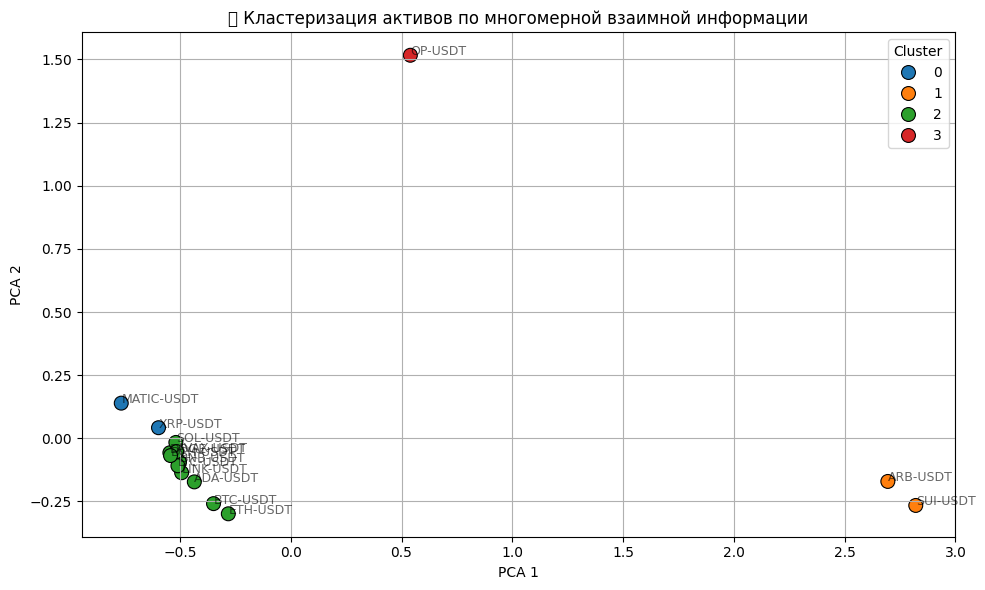

In [555]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

X = df_merged_mi_triple.drop(columns='Cluster')
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

df_merged_mi_triple['PCA1'] = X_pca[:, 0]
df_merged_mi_triple['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_merged_mi_triple,
    x='PCA1', y='PCA2',
    hue='Cluster',
    palette='tab10',
    s=100,
    edgecolor='black'
)

for i, txt in enumerate(df_merged_mi_triple.index):
    plt.annotate(txt, (df_merged_mi_triple.PCA1[i], df_merged_mi_triple.PCA2[i]), fontsize=9, alpha=0.6)

plt.title("🎯 Кластеризация активов по многомерной взаимной информации")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [1692]:
first_group_3 = ['OP-USDT']
second_group_3 = ['SUI-USDT', 'ARB-USDT']
third_group_3 = list(set(all_assets) - set(first_group_2) - set(second_group_2))
third_group_3

['BTC-USDT',
 'SUI-USDT',
 'SOL-USDT',
 'ADA-USDT',
 'LINK-USDT',
 'BNB-USDT',
 'LTC-USDT',
 'BCH-USDT',
 'DOGE-USDT',
 'AVAX-USDT',
 'MATIC-USDT',
 'XRP-USDT',
 'ETH-USDT']

In [1693]:
import numpy as np
import pandas as pd
import random

n_trials = 10000
structured_risks = []
random_risks = []

for _ in range(n_trials):
    asset1 = random.choice(first_group_3)
    asset2 = random.choice(second_group_3)
    asset3 = random.choice(third_group_3)
    portfolio_returns = returns[[asset1, asset2, asset3]].mean(axis=1)
    structured_risks.append(portfolio_returns.std())

    random_assets = random.sample(all_assets, 4)
    random_portfolio_returns = returns[random_assets].mean(axis=1)
    random_risks.append(random_portfolio_returns.std())


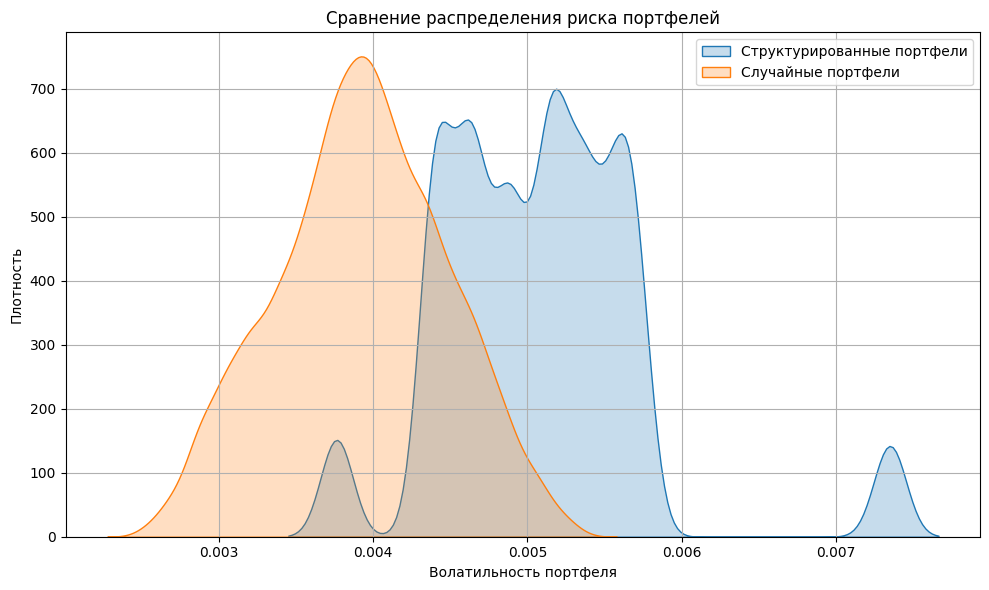

In [1694]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.kdeplot(structured_risks, label='Структурированные портфели', fill=True)
sns.kdeplot(random_risks, label='Случайные портфели', fill=True)
plt.xlabel('Волатильность портфеля')
plt.ylabel('Плотность')
plt.title('Сравнение распределения риска портфелей')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


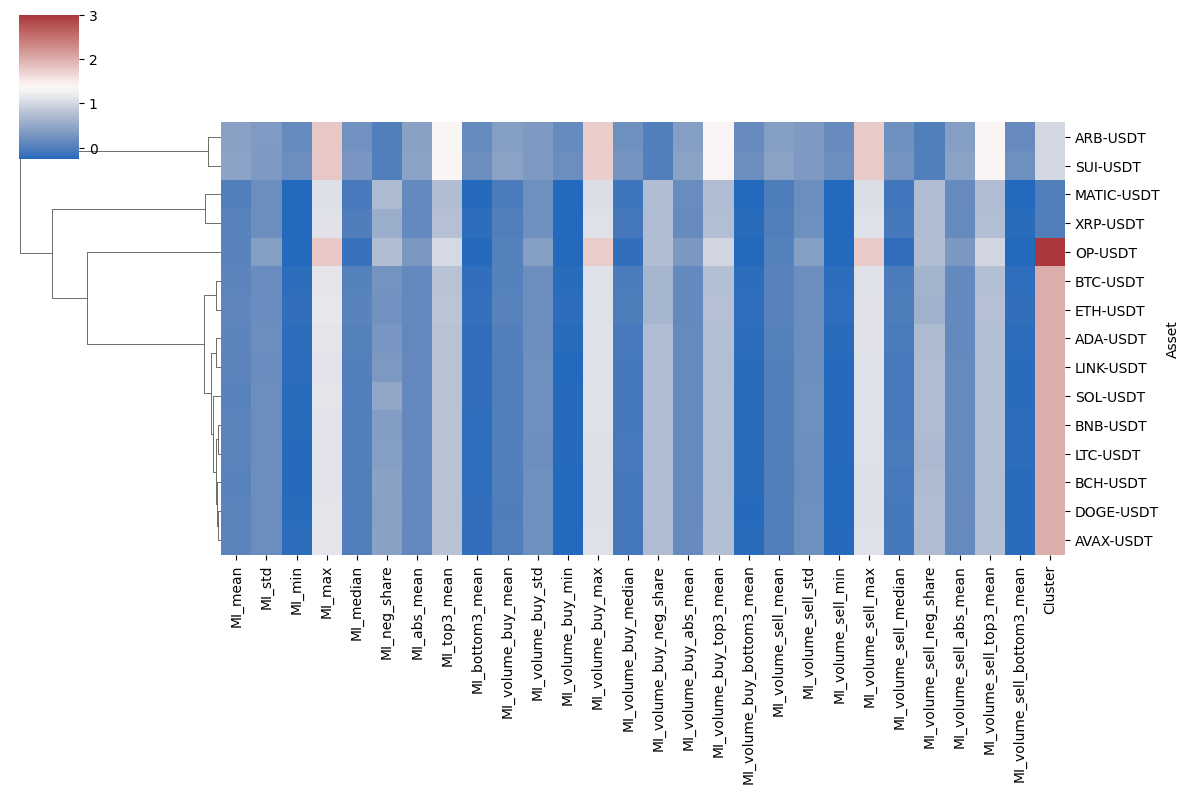

In [557]:
import seaborn as sns

sns.clustermap(
    df_merged_mi_triple.drop(columns=['PCA1', 'PCA2']).sort_values('Cluster'),
    cmap='vlag',
    figsize=(12, 8),
    row_cluster=True,
    col_cluster=False
)


In [1245]:
from collections import defaultdict
import pandas as pd

def build_mi_feature_matrix(df):
    feature_dict = defaultdict(dict)

    for _, row in df.iterrows():
        triple = [row['Asset1'], row['Asset2'], row['Asset3']]
        mi = row['Mutual_Information']
        
        for i, asset in enumerate(triple):
            others = tuple(sorted([triple[(i+1)%3], triple[(i+2)%3]]))
            key = f"MI_with_{others[0]}+{others[1]}"
            feature_dict[asset][key] = mi

    return pd.DataFrame.from_dict(feature_dict, orient='index').fillna(0)

In [1246]:
mi_df_log_returns = build_mi_feature_matrix(df_triple_mi_log_returns)
mi_df_volume_buy = build_mi_feature_matrix(df_triple_mi_volume_buy)
mi_df_volume_sell = build_mi_feature_matrix(df_triple_mi_volume_sell)
mi_df_volume_buy.columns = [col + '_volume_buy' for col in mi_df_volume_buy.columns]
mi_df_volume_sell.columns = [col + '_volume_sell' for col in mi_df_volume_sell.columns]

In [1188]:
mi_df_volume_buy

,MI_with_BNB-USDT+BTC-USDT_volume_buy,MI_with_BNB-USDT+DOGE-USDT_volume_buy,MI_with_BNB-USDT+ETH-USDT_volume_buy,MI_with_BNB-USDT+MATIC-USDT_volume_buy,MI_with_BNB-USDT+SOL-USDT_volume_buy,MI_with_BNB-USDT+XRP-USDT_volume_buy,MI_with_ADA-USDT+BNB-USDT_volume_buy,MI_with_BNB-USDT+OP-USDT_volume_buy,MI_with_BNB-USDT+LINK-USDT_volume_buy,MI_with_BNB-USDT+SUI-USDT_volume_buy,...,MI_with_ARB-USDT+SOL-USDT_volume_buy,MI_with_ARB-USDT+XRP-USDT_volume_buy,MI_with_ADA-USDT+ARB-USDT_volume_buy,MI_with_ARB-USDT+OP-USDT_volume_buy,MI_with_ARB-USDT+LINK-USDT_volume_buy,MI_with_ARB-USDT+SUI-USDT_volume_buy,MI_with_ARB-USDT+AVAX-USDT_volume_buy,MI_with_ARB-USDT+LTC-USDT_volume_buy,MI_with_ARB-USDT+BCH-USDT_volume_buy,MI_with_ARB-USDT+BNB-USDT_volume_buy
ARB-USDT,0.21689292,0.18736506,0.22537595,0.16379754,0.20859113,0.19515685,0.21222774,0.55654055,0.19784481,1.10005246,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
DOGE-USDT,-0.07200547,0.00000000,-0.06633210,-0.14508129,-0.10621322,-0.10520631,-0.08515636,-0.21454566,-0.10288551,0.24603313,...,0.19740791,0.18900149,0.20514914,0.55205388,0.19616531,1.08910187,0.19434362,0.19653261,0.18954181,0.18736506
ETH-USDT,0.06656101,-0.06633210,0.00000000,-0.06911161,-0.02250052,-0.05508188,-0.01460918,-0.16503132,-0.02523701,0.26350458,...,0.23849996,0.21469610,0.23859330,0.59266595,0.22784182,1.10582308,0.22853335,0.22520763,0.21594012,0.22537595
MATIC-USDT,-0.07907476,-0.14508129,-0.06911161,0.00000000,-0.11445026,-0.13677749,-0.09886412,-0.23570477,-0.11625031,0.21065627,...,0.17138583,0.15599578,0.17743950,0.52608931,0.16639234,1.06292636,0.16665448,0.15969644,0.15248186,0.16379754
SOL-USDT,-0.02880043,-0.10621322,-0.02250052,-0.11445026,0.00000000,-0.09812831,-0.06293940,-0.19812079,-0.07509862,0.25650238,...,0.00000000,0.19802085,0.22095131,0.56466887,0.21195939,1.10010650,0.21802143,0.20571498,0.19961826,0.20859113
XRP-USDT,-0.05460384,-0.10520631,-0.05508188,-0.13677749,-0.09812831,0.00000000,-0.07190522,-0.21279084,-0.09172898,0.25463011,...,0.19802085,0.00000000,0.20936467,0.55047409,0.19883444,1.09437465,0.19501804,0.19681344,0.18830433,0.19515685
ADA-USDT,-0.02080557,-0.08515636,-0.01460918,-0.09886412,-0.06293940,-0.07190522,0.00000000,-0.18956250,-0.05985075,0.26051998,...,0.22095131,0.20936467,0.00000000,0.57374044,0.21627929,1.10370902,0.21702420,0.21252410,0.20424727,0.21222774
OP-USDT,-0.17697615,-0.21454566,-0.16503132,-0.23570477,-0.19812079,-0.21279084,-0.18956250,0.00000000,-0.20415113,0.59886372,...,0.56466887,0.55047409,0.57374044,0.00000000,0.55965198,1.75348388,0.56435309,0.55933534,0.55236159,0.55654055
LINK-USDT,-0.03439063,-0.10288551,-0.02523701,-0.11625031,-0.07509862,-0.09172898,-0.05985075,-0.20415113,0.00000000,0.25132034,...,0.21195939,0.19883444,0.21627929,0.55965198,0.00000000,1.09487263,0.20602960,0.20031356,0.19521034,0.19784481
SUI-USDT,0.26327915,0.24603313,0.26350458,0.21065627,0.25650238,0.25463011,0.26051998,0.59886372,0.25132034,0.00000000,...,1.10010650,1.09437465,1.10370902,1.75348388,1.09487263,0.00000000,1.09492965,1.09147112,1.08863917,1.10005246


In [1247]:
mi_fingerprint_df = pd.concat(
    [mi_df_log_returns, mi_df_volume_buy, mi_df_volume_sell],
    axis=1,
    join='inner'
)rolling_entropy


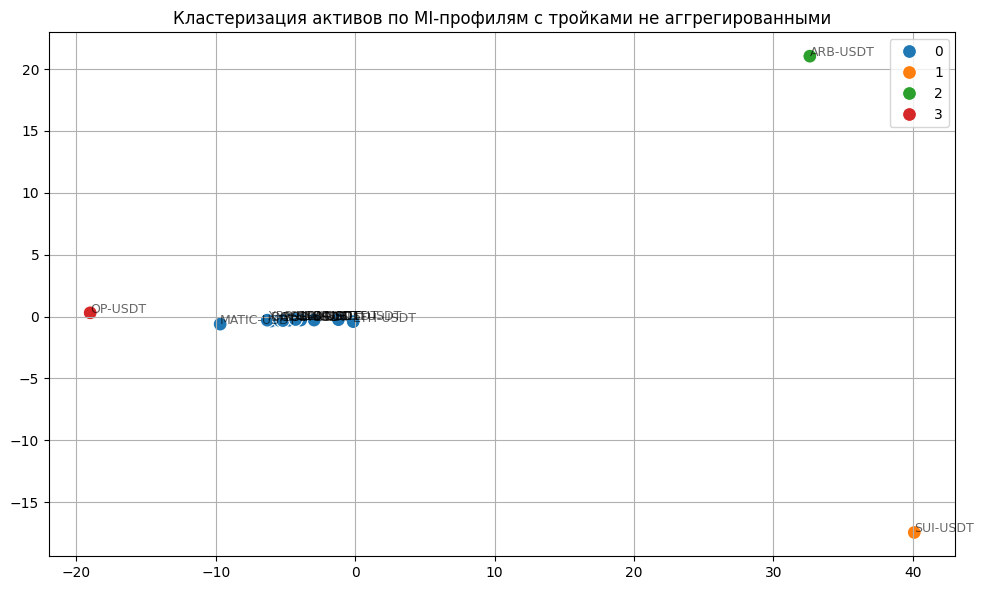

In [1248]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

X = StandardScaler().fit_transform(mi_fingerprint_df)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

labels = KMeans(n_clusters=4, random_state=42).fit_predict(X)


plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette='tab10', s=100)

for i, asset in enumerate(mi_fingerprint_df.index):
    plt.text(X_pca[i,0], X_pca[i,1], asset, fontsize=9, alpha=0.6)

plt.title("Кластеризация активов по MI-профилям с тройками не аггрегированными")
plt.grid(True)
plt.tight_layout()
plt.show()


In [1660]:
mi_df_log_returns = compute_mutual_info_matrix(disc_windows_week_story_log_returns.fillna(0))
mi_df_volume_buy = compute_mutual_info_matrix(disc_windows_week_story_volume_buy.fillna(0))
mi_df_volume_sell = compute_mutual_info_matrix(disc_windows_week_story_volume_sell.fillna(0))
mi_df_volume_buy.columns = [col + '_volume_buy' for col in mi_df_volume_buy.columns]
mi_df_volume_sell.columns = [col + '_volume_sell' for col in mi_df_volume_sell.columns]

In [1664]:
mi_df_log_returns_prev = compute_mutual_info_matrix(disc_windows_week_story_log_returns[disc_windows_week_story_log_returns.index <= '2024-09-01'].fillna(0))
mi_df_volume_buy_prev = compute_mutual_info_matrix(disc_windows_week_story_volume_buy[disc_windows_week_story_volume_buy.index <= '2024-09-01'].fillna(0))
mi_df_volume_sell_prev = compute_mutual_info_matrix(disc_windows_week_story_volume_sell[disc_windows_week_story_volume_sell.index <= '2024-09-01'].fillna(0))


In [1665]:
mi_fingerprint_df_2 = pd.concat(
    [mi_df_log_returns_prev, mi_df_volume_buy_prev, mi_df_volume_sell_prev],
    axis=1,
    join='inner'
)


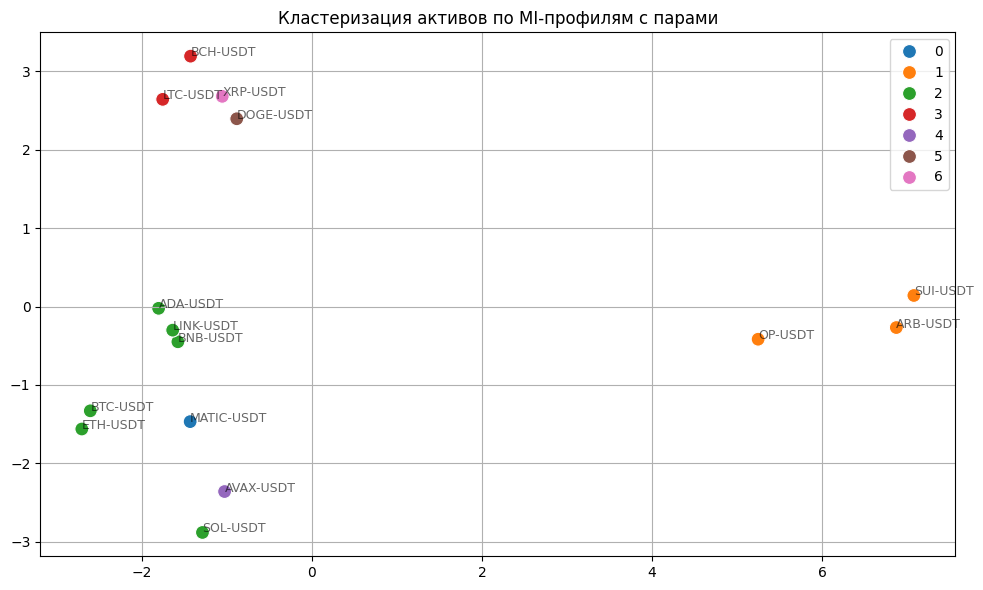

In [1701]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

X = StandardScaler().fit_transform(mi_fingerprint_df_2)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

labels = KMeans(n_clusters=7, random_state=42).fit_predict(X)


plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette='tab10', s=100)

for i, asset in enumerate(mi_fingerprint_df_2.index):
    plt.text(X_pca[i,0], X_pca[i,1], asset, fontsize=9, alpha=0.6)

plt.title("Кластеризация активов по MI-профилям с парами")
plt.grid(True)
plt.tight_layout()
plt.show()


In [1667]:
first_group = ['ETH-USDT', 'BTC-USDT', 'MATIC-USDT', 'BNB-USDT', 'LINK-USDT', 'ADA-USDT', 'AVAX-USDT', 'SOL-USDT']
second_group = ['LTC-USDT', 'BCH-USDT', 'XRP-USDT', 'DOGE-USDT']
third_group = ['OP-USDT', 'ARB-USDT', 'SUI-USDT']

In [1677]:
all_assets = first_group + second_group + third_group

In [1671]:
prices_top = df['close'][TOP_UNIVERSE]

In [1682]:
returns = prices_top.pct_change().loc['2024-09-01 00:30:00': '2024-09-30 00:00:00']
returns

/tmp/ipykernel_395875/1387951274.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices_top.pct_change().loc['2024-09-01 00:30:00': '2024-09-30 00:00:00']


ticker,ARB-USDT,BNB-USDT,BTC-USDT,DOGE-USDT,ETH-USDT,MATIC-USDT,SOL-USDT,XRP-USDT,ADA-USDT,OP-USDT,LINK-USDT,SUI-USDT,AVAX-USDT,LTC-USDT,BCH-USDT
endRange,,,,,,,,,,,,,,,
2024-09-01 00:30:00,-0.00330994,-0.00212076,-0.00031212,-0.00187678,-0.00203422,-0.00285991,-0.00157461,-0.00123653,-0.00290019,0.00190703,-0.00417836,-0.00037697,-0.00210649,-0.00292627,-0.00096255
2024-09-01 01:00:00,0.00058603,-0.00278360,-0.00038182,0.00029692,-0.00094147,-0.00239003,0.00188801,-0.00106116,0.00087257,-0.00281984,0.00155060,0.00439980,0.00131932,-0.00231698,0.00108782
2024-09-01 01:30:00,-0.00351425,-0.00320612,-0.00019861,-0.00168184,-0.00058294,0.00119788,-0.00530627,-0.00106239,-0.00377799,-0.00183807,-0.00245897,-0.00438053,-0.00228391,-0.00247710,-0.00180074
2024-09-01 02:00:00,-0.00607362,-0.00315985,-0.00151803,-0.00525218,-0.00409905,-0.00813591,-0.00747431,-0.00549447,-0.00495911,-0.00672854,-0.00465623,-0.00741668,-0.00796794,-0.00388018,-0.00497629
2024-09-01 02:30:00,-0.00768774,-0.00379615,-0.00873915,-0.00508076,-0.00629822,-0.00747891,-0.00479827,-0.00392088,-0.00322487,-0.00477755,-0.00550362,-0.00367275,-0.01229201,-0.00202551,-0.00403228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-29 22:00:00,0.00092163,0.00026648,0.00014431,0.00023591,0.00085979,0.00000000,-0.00408238,0.00436077,-0.00298728,0.00466355,-0.00418381,-0.00172339,-0.00249206,-0.00313660,0.00033711
2024-09-29 22:30:00,-0.00537137,-0.00254787,-0.00189701,-0.00825598,-0.00154932,0.00000000,-0.00207454,-0.00434183,-0.00549315,-0.00777133,-0.00483550,-0.00707243,-0.00366182,-0.00228827,-0.00525176
2024-09-29 23:00:00,-0.00185160,-0.00265465,-0.00122653,-0.00261636,-0.00271260,0.00000000,-0.00457093,-0.00295897,-0.00100429,-0.00431037,-0.00270826,-0.00622543,-0.00212964,-0.00157684,-0.00369847


In [1685]:
import numpy as np
import pandas as pd
import random

n_trials = 10000
structured_risks = []
random_risks = []

for _ in range(n_trials):
    asset1 = random.choice(first_group)
    asset2 = random.choice(second_group)
    asset3 = random.choice(third_group)
    portfolio_returns = returns[[asset1, asset2, asset3]].mean(axis=1)
    structured_risks.append(portfolio_returns.std())

    random_assets = random.sample(all_assets, 3)
    random_portfolio_returns = returns[random_assets].mean(axis=1)
    random_risks.append(random_portfolio_returns.std())


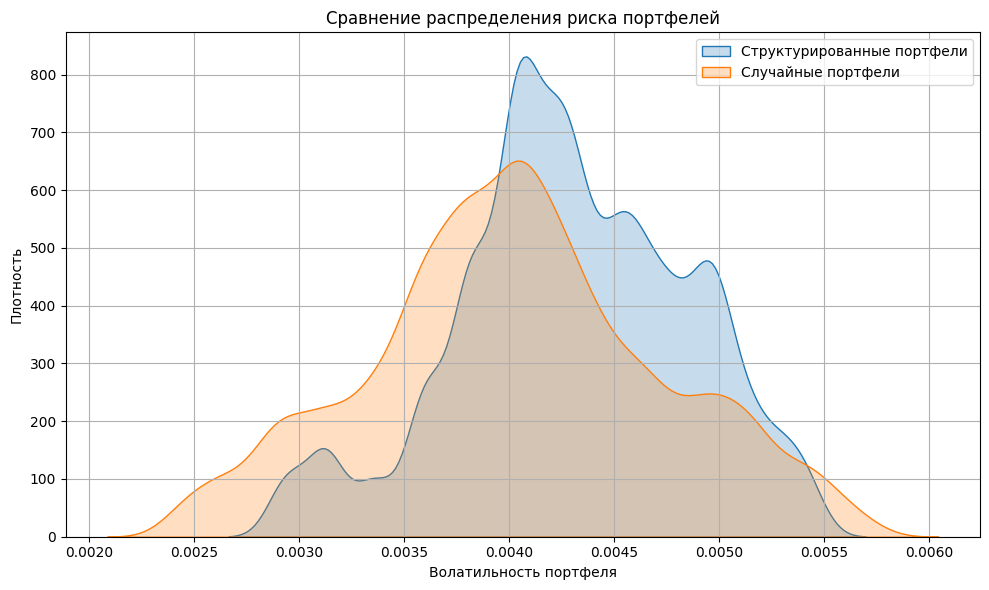

In [1686]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.kdeplot(structured_risks, label='Структурированные портфели', fill=True)
sns.kdeplot(random_risks, label='Случайные портфели', fill=True)
plt.xlabel('Волатильность портфеля')
plt.ylabel('Плотность')
plt.title('Сравнение распределения риска портфелей')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1696]:
first_group_4 = ['BNB-USDT', 'LINK-USDT', 'ADA-USDT']
second_group_4 = ['LTC-USDT', 'BCH-USDT', 'XRP-USDT', 'DOGE-USDT']
third_group_4 = ['OP-USDT', 'ARB-USDT', 'SUI-USDT']
fourth_group_4 = ['MATIC-USDT']
fifth_group_4 = ['BTC-USDT', 'ETH-USDT']
sixth_group_4 = ['AVAX-USDT', 'SOL-USDT']

In [1698]:
import numpy as np
import pandas as pd
import random

n_trials = 10000
structured_risks = []
random_risks = []

for _ in range(n_trials):
    asset1 = random.choice(first_group_4)
    asset2 = random.choice(second_group_4)
    asset3 = random.choice(third_group_4)
    asset4 = random.choice(fourth_group_4)
    asset5 = random.choice(fifth_group_4)
    asset6 = random.choice(sixth_group_4)
    portfolio_returns = returns[[asset1, asset2, asset3, asset4, asset5, asset6]].mean(axis=1)
    structured_risks.append(portfolio_returns.std())
    random_assets = random.sample(all_assets, 3)
    random_portfolio_returns = returns[random_assets].mean(axis=1)
    random_risks.append(random_portfolio_returns.std())


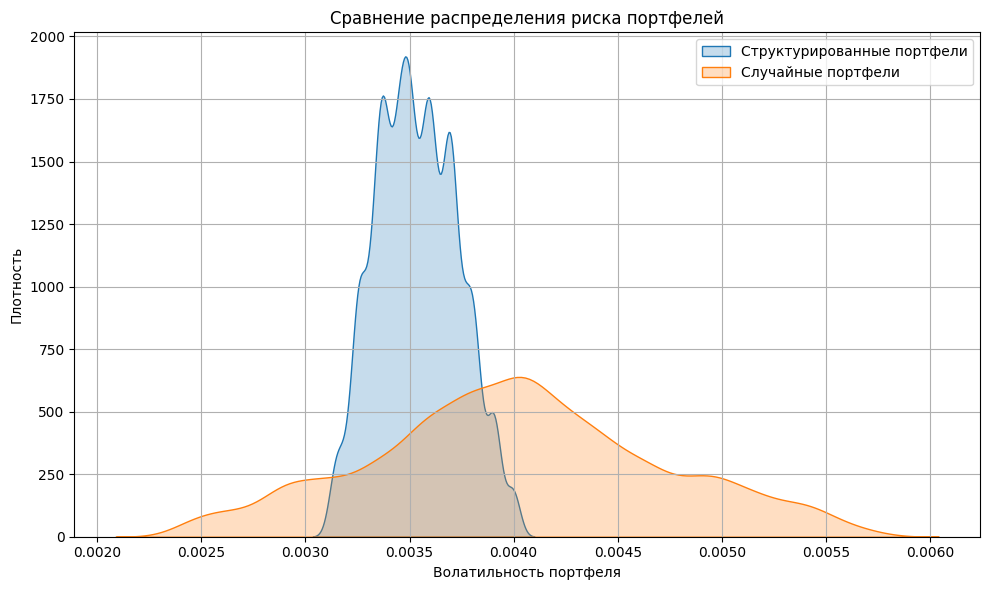

In [1699]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.kdeplot(structured_risks, label='Структурированные портфели', fill=True)
sns.kdeplot(random_risks, label='Случайные портфели', fill=True)
plt.xlabel('Волатильность портфеля')
plt.ylabel('Плотность')
plt.title('Сравнение распределения риска портфелей')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1194]:
combined_fingerprint_df = pd.concat(
    [mi_fingerprint_df, mi_fingerprint_df_2],
    axis=1,
    join='inner' 
)

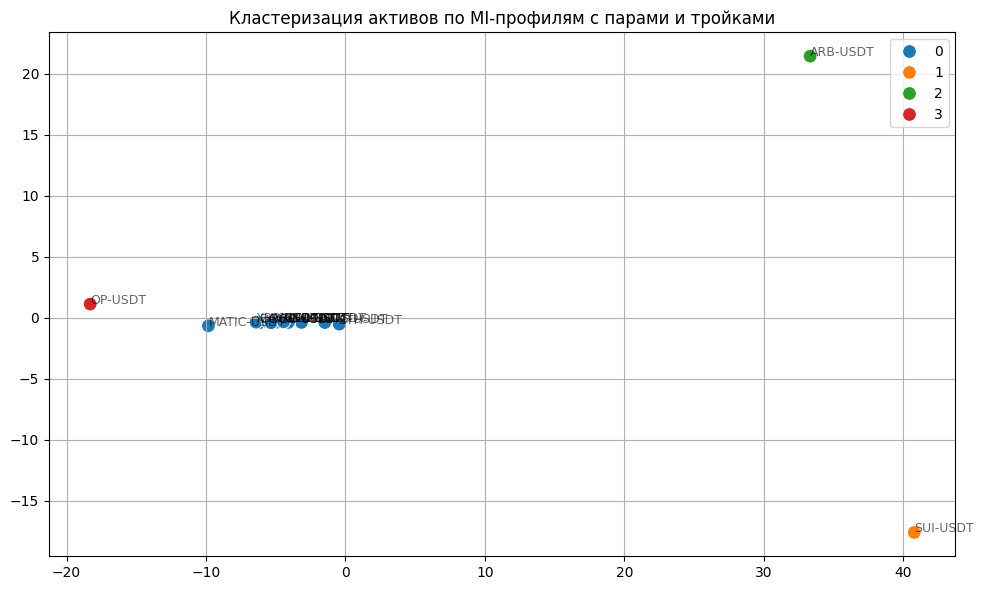

In [1244]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

X = StandardScaler().fit_transform(combined_fingerprint_df)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

labels = KMeans(n_clusters=4, random_state=42).fit_predict(X)


plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette='tab10', s=100)

for i, asset in enumerate(combined_fingerprint_df.index):
    plt.text(X_pca[i,0], X_pca[i,1], asset, fontsize=9, alpha=0.6)

plt.title("Кластеризация активов по MI-профилям с парами и тройками")
plt.grid(True)
plt.tight_layout()
plt.show()


In [1689]:
import numpy as np
import pandas as pd
import random

n_trials = 10000
structured_risks = []
random_risks = []

for _ in range(n_trials):
    asset1 = random.choice(first_group_2)
    asset2 = random.choice(second_group_2)
    asset3 = random.choice(third_group_2)
    asset4 = random.choice(four_group_2)
    portfolio_returns = returns[[asset1, asset2, asset3, asset4]].mean(axis=1)
    structured_risks.append(portfolio_returns.std())

    random_assets = random.sample(all_assets, 4)
    random_portfolio_returns = returns[random_assets].mean(axis=1)
    random_risks.append(random_portfolio_returns.std())


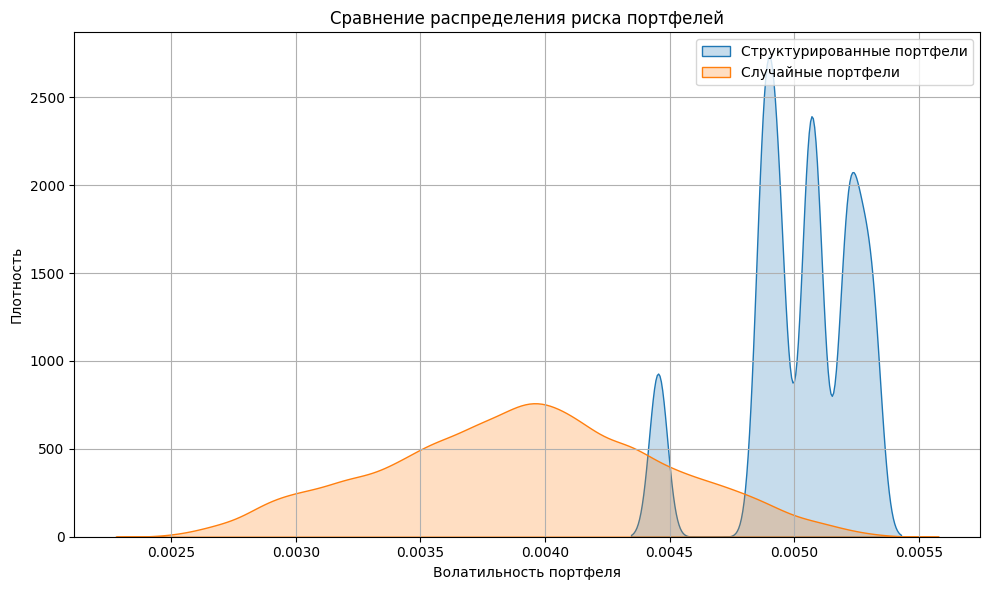

In [1691]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.kdeplot(structured_risks, label='Структурированные портфели', fill=True)
sns.kdeplot(random_risks, label='Случайные портфели', fill=True)
plt.xlabel('Волатильность портфеля')
plt.ylabel('Плотность')
plt.title('Сравнение распределения риска портфелей')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
first_group_2 = ['OP-USDT']
second_group_2  = ['ARB-USDT']
third_group_2 = ['SUI-USDT']
four_group_2 = list(set(all_assets) - set(first_group_2) - set(second_group_2) - set(third_group_2))
four_group_2

In [1249]:
correlation_matrix_log_returns = log_returns.corr(method = 'pearson')
correlation_matrix_log_returns.style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1)

ticker,ARB-USDT,BNB-USDT,BTC-USDT,DOGE-USDT,ETH-USDT,MATIC-USDT,SOL-USDT,XRP-USDT,ADA-USDT,OP-USDT,LINK-USDT,SUI-USDT,AVAX-USDT,LTC-USDT,BCH-USDT
ticker,,,,,,,,,,,,,,,
ARB-USDT,1.000000,0.643302,0.675156,0.612569,0.778328,0.739095,0.652887,0.542005,0.704067,0.776265,0.694528,0.638260,0.673833,0.662477,0.571715
BNB-USDT,0.643302,1.000000,0.710720,0.472416,0.739590,0.636231,0.607991,0.591874,0.681288,0.593654,0.712458,0.553510,0.629498,0.682843,0.640877
BTC-USDT,0.675156,0.710720,1.000000,0.516918,0.854506,0.632916,0.639732,0.612100,0.700799,0.605646,0.728516,0.553044,0.641184,0.749389,0.697396
DOGE-USDT,0.612569,0.472416,0.516918,1.000000,0.524792,0.440984,0.445992,0.432600,0.492905,0.563451,0.509430,0.538031,0.449889,0.505825,0.478887
ETH-USDT,0.778328,0.739590,0.854506,0.524792,1.000000,0.680133,0.672068,0.629088,0.731367,0.680274,0.794133,0.588910,0.676866,0.771577,0.714927
MATIC-USDT,0.739095,0.636231,0.632916,0.440984,0.680133,1.000000,0.589569,0.542945,0.643615,0.664142,0.673396,0.637304,0.612194,0.622767,0.587205
SOL-USDT,0.652887,0.607991,0.639732,0.445992,0.672068,0.589569,1.000000,0.522776,0.628353,0.593240,0.658949,0.587356,0.621938,0.614441,0.578056
XRP-USDT,0.542005,0.591874,0.612100,0.432600,0.629088,0.542945,0.522776,1.000000,0.622553,0.499340,0.626755,0.474863,0.545919,0.629032,0.601778
ADA-USDT,0.704067,0.681288,0.700799,0.492905,0.731367,0.643615,0.628353,0.622553,1.000000,0.637158,0.737933,0.612331,0.658706,0.703168,0.665898


In [1251]:
correlation_matrix_volumes_buy = volumes_buy.corr(method = 'pearson')
correlation_matrix_volumes_sell = volumes_sell.corr(method = 'pearson')
correlation_matrix_volumes_buy.columns = [col + '_volume_buy' for col in correlation_matrix_volumes_buy.columns]
correlation_matrix_volumes_sell.columns = [col + '_volume_sell' for col in correlation_matrix_volumes_sell.columns]

In [1252]:
mi_fingerprint_df_corr = pd.concat(
    [correlation_matrix_log_returns, correlation_matrix_volumes_buy, correlation_matrix_volumes_sell],
    axis=1,
    join='inner'
)

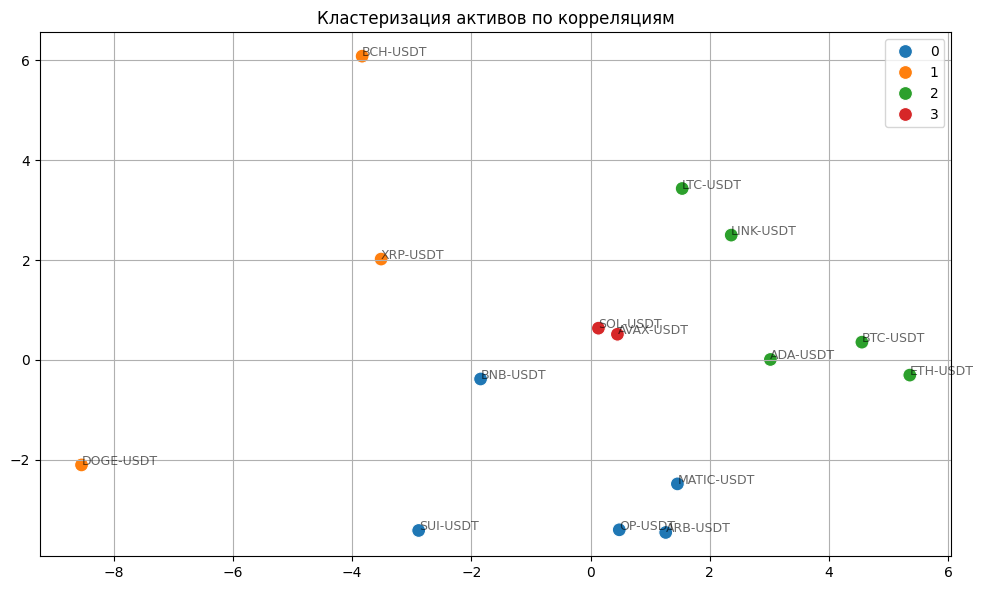

In [1253]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

X = StandardScaler().fit_transform(mi_fingerprint_df_corr)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

labels = KMeans(n_clusters=4, random_state=42).fit_predict(X)


plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette='tab10', s=100)

for i, asset in enumerate(mi_fingerprint_df_corr.index):
    plt.text(X_pca[i,0], X_pca[i,1], asset, fontsize=9, alpha=0.6)

plt.title("Кластеризация активов по корреляциям")
plt.grid(True)
plt.tight_layout()
plt.show()
